In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt

# **1) GENERATION DES DONNEES**

On tire un échantillon i.i.d. de $z_i$ de densité $q_{\phi}(.|x)$. Dans notre application on définit $q_{\phi}(.|x)$ comme une loi normale multivariée de moyenne nulle et de matrice de variance-covariance $2/3*I$. Nous ne considérons pas dans notre application de perturbations additionnelles sur cette distribution. Ainsi, ${\phi} = (I,0)$.

In [2]:
def generate_z(K,x_data):
    z_O, z_E = [],[]
    for i in range(int(2**K)):
        z_O.append(np.random.multivariate_normal(x_data, (2/3)*np.identity(20)))
        z_E.append(np.random.multivariate_normal(x_data, (2/3)*np.identity(20)))
    z = z_O.copy()
    z.extend(z_E)
    return z, z_O, z_E

In [3]:
np.random.seed(0)
generate_z(0,np.zeros((20)))

([array([ 1.44034271,  0.32672699,  0.79913622,  1.82968164,  1.52485471,
         -0.79794405,  0.77574394, -0.12358264, -0.08427784,  0.33525227,
          0.11761108,  1.18740935,  0.6213847 ,  0.09934723,  0.36241281,
          0.27244395,  1.21991045, -0.16751102,  0.25561871, -0.69736625]),
  array([-2.08450746,  0.53367735,  0.7058092 , -0.6059752 ,  1.85324689,
         -1.1874846 ,  0.03736167, -0.15283497,  1.25150899,  1.19972641,
          0.12651404,  0.3087684 , -0.72487403, -1.61731354, -0.28406908,
          0.1276584 ,  1.00452813,  0.98173904, -0.31625102, -0.24682916])],
 [array([ 1.44034271,  0.32672699,  0.79913622,  1.82968164,  1.52485471,
         -0.79794405,  0.77574394, -0.12358264, -0.08427784,  0.33525227,
          0.11761108,  1.18740935,  0.6213847 ,  0.09934723,  0.36241281,
          0.27244395,  1.21991045, -0.16751102,  0.25561871, -0.69736625])],
 [array([-2.08450746,  0.53367735,  0.7058092 , -0.6059752 ,  1.85324689,
         -1.1874846 ,  0.03736

On doit maintenant tirer $q_{\phi}(z|x)$ et la loi jointe $p_{\theta}(x,z)$. Conformément à la procédure décrite dans l'article on tire $q_{\phi}(z|x)$ comme une loi normale de

In [4]:
def generate_q_p(K,mean,x_data,z,z_O,z_E):
    q,p,q_O,p_O,q_E,p_E = [],[],[],[],[],[]
    for i in range(int(2**(K+1))):
        q.append(multivariate_normal.pdf(z[i], mean=x_data, cov=(2/3)*np.identity(20)))
        p.append(multivariate_normal.pdf(z[i], mean=mean, cov=np.identity(20))*multivariate_normal.pdf(x_data, mean=z[i], cov=np.identity(20)))
    for i in range(int(2**(K))):
        q_O.append(multivariate_normal.pdf(z_O[i], mean=x_data, cov=(2/3)*np.identity(20)))
        p_O.append(multivariate_normal.pdf(z_O[i], mean=mean, cov=np.identity(20))*multivariate_normal.pdf(x_data, mean=z_O[i], cov=np.identity(20)))
        q_E.append(multivariate_normal.pdf(z_E[i], mean=x_data, cov=(2/3)*np.identity(20)))
        p_E.append(multivariate_normal.pdf(z_E[i], mean=mean, cov=np.identity(20))*multivariate_normal.pdf(x_data, mean=z_E[i], cov=np.identity(20)))
    return q, p, q_O, p_O, q_E, p_E

# **2) FONCTIONS**

In [5]:
def sum_w(K,w):
    sum_w=0
    for i in range(int(K)):
        sum_w += np.exp(w[i])
    return sum_w

In [6]:
def pi(K,w,p):
    sum_grad = 0
    for i in range(int(K)):
        sum_grad += (w[i]/sum_w(K,w))*np.gradient(p)[i]
    return sum_grad

K = taille de l'échantillon = aléatoire et généré selon une loi géométrique de paramètre 0.6

In [7]:
def grad_ss(n_sim, mean, r, x_data, theta):
    grad_vector = []
    x = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
    for i in range(n_sim):
        K = np.random.geometric(r, 1)
        z, z_O, z_E = generate_z(K,x_data)
        q, p, q_O, p_O, q_E, p_E = generate_q_p(K,mean,x_data,z,z_O,z_E)
        w = np.log(p) - np.log(q)
        w_O = np.log(p_O) - np.log(q_O)
        w_E = np.log(p_E) - np.log(q_E)
            
        #third step : compute I0
        I0 = w.mean()

        #fourth step : compute Lo and Le
            # Lo
        pi_O = pi(K,w_O,p_O)  
            #Le
        pi_E = pi(K,w_E,p_E)    

        #fifth step : compute L_O_E
        pi_O_E = pi(K,w,p)
    
        #DeltaK
        DeltaK = pi_O_E - 0.5*(pi_O + pi_E)
    
        #sixth step : compute the final estimator
        grad = I0 + (DeltaK/(r*(1-r)**(int(K)-1)))
        
        grad_vector.append(grad)
    mean_value = np.mean(grad_vector)
    #std_error_value = np.std(grad_vector) / np.sqrt(len(grad_vector))

    return mean_value

In [8]:
theta = np.random.normal(0,1)
print("Theta = " + str('{:.2f}'.format((theta))))
x_data = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
grad_ss(100, np.zeros(20), 0.6, x_data, theta)

Theta = -1.05


-66.55115973440422

# **3) DESCENTE DE GRADIENT**
Test performances estimateur gradient ML-SS

In [9]:
def gradient_descent(n_sim, mean, r, theta, precision, learning_rate = 0.01):
  start = 0
  gradient_update = []
  gradient_update.append(grad_ss(n_sim, mean, r, x_data, theta))
  iteration = 0
  while gradient_update[iteration] - gradient_update[iteration - 1] >= precision:
    gradient_update.append(gradient_update[iteration] - learning_rate * grad_ss(n_sim, gradient_update[iteration], r, x_data, theta))
  return gradient_update[-1]

# **4) FONCTION POUR PLOT LE GRADIENT ESTIME**

In [13]:
def plot_grad(debut,fin,pas,n_sim,x_data):
    for i in range(n_sim):
        liste = np.linspace(debut,fin,pas)
        x = []
        y = []
        for k in liste:
            y.append(grad_ss(100, np.zeros(20)+k, 0.6, x_data, theta))
            x.append(k)
        print(str('{:.2f}'.format((i+1)/n_sim)))              
    return x, y

Theta = -0.42
0.33
0.67
1.00


[]

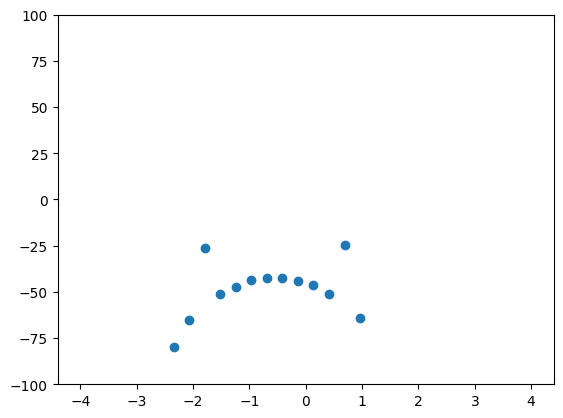

In [14]:
theta = np.random.normal(0,1)
print("Theta = " + str('{:.2f}'.format((theta))))
x_data = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
x_grad,y_grad = plot_grad(debut=-4,fin=4,pas=30,n_sim=3,x_data=x_data)
plt.scatter(x_grad,y_grad)
plt.ylim((-100,100))
plt.plot()

In [ ]:
x_grad

# **5) ESTIMATION GRADIENT IWAE**

CF FORMULE (11) ARTICLE

In [17]:
def gradient_loglikelihood_estimator(n_sim, mean, r, x_data, theta):
  w_bar = []      # vecteur qui contient les w_bar_i décrits dans l'équation (4) de l'article
  x = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
  for i in range(n_sim):
    K = np.random.geometric(r, 1)
    z, z_O, z_E = generate_z(K,x_data)
    q, p, q_O, p_O, q_E, p_E = generate_q_p(K,mean,x_data,z,z_O,z_E)
    w = [m/n for m, n in zip(p, q)] # on obtient les w_i
  for i in range(len(w)):
    w_bar.append(w[i] / np.sum(w)) #w bar i 
  IWAE_gradient_estimator = 0
  for i in range(len(z)):
    IWAE_gradient_estimator += w_bar[i] * np.gradient(p) 
  return IWAE_gradient_estimator

In [21]:
def plot_grad_2(debut,fin,pas,n_sim,x_data):
    for i in range(n_sim):
        liste = np.linspace(debut,fin,pas)
        x = []
        y = []
        for k in liste:
            y.append(gradient_loglikelihood_estimator(1, np.zeros(20)+k, 0.6, x_data, theta))
            x.append(k)
        print(str('{:.2f}'.format((i+1)/n_sim)))              
    return x, y

In [19]:
print("Theta = " + str('{:.2f}'.format((theta))))
x_data = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
x_grad,y_grad = plot_grad_2(debut=-4, fin=4, pas=30, n_sim=3, x_data=x_data)
gradient_values = gradient_loglikelihood_estimator(100, np.zeros((20)), 0.6, x_data, theta)
print(type(x_grad), type(y_grad))
#plt.scatter(x_grad,y_grad)
#plt.plot()

Theta = -0.42
0.33
0.67
1.00
<class 'list'> <class 'list'>


In [ ]:
plt.scatter(x_grad,y_grad)
plt.plot()